In [1]:
#import libraries

import pandas as pd
import numpy as np

from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.externals.six import StringIO
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

%matplotlib inline
import seaborn as sns
from IPython.display import Image
import pydotplus
from sklearn.tree import export_graphviz

In [2]:
#import data from crash_summary.csv 
crash_data = pd.read_csv("ct_bike_crash_data/crash_summary.csv")

#cleanup field headers
crash_data.columns = crash_data.columns.str.replace('\s+', '_')

#drop unnecessary fields
crash_data.drop(['Severity',
                 'DOT_Case_Number',
                 'Severity', 
                 'Severity_Text_Format', 
                 'Most_Severe_Injury',
                 'Number_Of_Pedestrians',
                 'Number_Of_Qualifying_Commercial_Vehicles',
                 'Town',
                 'Town_Text_Format',
                 'Route_Class',
                 'Route_or_Local_Road_Number',
                 'Route_Direction',
                 'Cumulative_Route_Mileage',
                 'Ramp_or_Turning_Road_Number',
                 'Ramp_Letter',
                 'At_or_Between_Intersections',
                 'Intersecting_Leg_#1',
                 'Intersecting_Leg_#2',
                 'Intersecting_Leg_#3',
                 'Intersecting_Leg_#4',
                 'Name_of_Road_that_Crash_Occurred_On',
                 'Name_or_Route_Number_of_Road_at_which_Crash_Occurred',
                 'Measure_Distance',
                 'Unit_Of_Measure',
                 'Unit_Of_Measure_Text_Format',
                 'Measure_Direction',
                 'Measure_Direction_Text_Format',
                 'Name_of_Nearest_Intersection,_Street,_Town_Line_or_Mile_Marker',
                 'Alpha_Description_of_Crash_Location',
                 'Collision_Type',
                 'Collision_Type_Text_Format',
                 'Weather_Condition',
                 'Road_Surface_Condition',
                 'Light_Condition',
                 'Crash_Occurred_On',
                 'Crash_Occurred_On_Text_Format',
                 'Other_Roadway_Feature',
                 'Other_Roadway_Feature_Text_Format',
                 'Median_Barrier_Penetration',
                 'Median_Barrier_Penetration_Text_Format',
                 'Construction_or_Maintenance_Related',
                 'At-Fault_Traffic_Unit_Number',
                 'Contributing_Factor',
                 'Contributing_Factor_Text_Format',
                 'Average_Daily_Traffic',
                 'Rural_or_Urban',
                 'Rural_or_Urban_Text_Format',
                 'Number_of_Lanes',
                 'Route_Direction_Text_Format'],
                 axis=1, inplace=True)

#cleanup field headers again
crash_data.columns = crash_data.columns.str.replace('_Text_Format', '')

#do some datetime stuff to get hour and DOW - I have decided not to use these factors in the final model, but have
#left the code in case that changes.
crash_data['Crash_Date_Time'] = crash_data.apply(lambda x: x['Date_Of_Crash'] + ' ' + x['Time_Of_Crash'] , axis = 1)
crash_data.Crash_Date_Time = pd.to_datetime(crash_data.Crash_Date_Time,format="%m/%d/%Y %H:%M:%S")
del crash_data['Date_Of_Crash']
del crash_data['Time_Of_Crash']
#crash_data['Crash_DOW'] = crash_data.Crash_Date_Time.dt.weekday_name
#crash_data['Crash_Hour'] = crash_data.Crash_Date_Time.dt.hour
del crash_data['Crash_Date_Time']

#below functions are made to simplfy some of the categorical variables
def convert_weather(x):
    if x=="Rain" or x=="Snow" or x=="Sleet, Hail":
        return "Precipitation"
    elif x=="No Adverse Condition":
        return x
    else:
        return "Other"
crash_data['Weather_Condition'] = crash_data.apply(lambda x: convert_weather(x['Weather_Condition']), axis=1)

def convert_surface(x):
    if x=="Dry" or x=="Wet":
        return x
    elif x=="Sand, Mud, Dirt or Oil" or x=="Snow/Slush" or x=="Ice":
        return "Slick"
    else:
        return "Other"
crash_data['Road_Surface_Condition'] = crash_data.apply(lambda x: convert_surface(x['Road_Surface_Condition']), 
                                                        axis=1)    
def convert_light(x):
    if x=="Daylight" or x=="Unknown":
        return x
    elif x=="Dark-Lighted" or x=="Dusk" or x=="Dawn":
        return "Low_Light"
    else:
        return "Dark"
crash_data['Light_Condition'] = crash_data.apply(lambda x: convert_light(x['Light_Condition']), axis=1)
    
#creating dummies for all of these categorical variables
for i in range(3,9):
    if crash_data.columns[i] == 'Construction_or_Maintenance_Related':
        dummies = pd.get_dummies(crash_data.iloc[:,i], drop_first=True, prefix = 'Construction').astype(int)
    elif crash_data.columns[i] == 'Weather_Condition':
        dummies = pd.get_dummies(crash_data.iloc[:,i], drop_first=True, prefix = 'Weather').astype(int)
    elif crash_data.columns[i] == 'Road_Surface_Condition':
        dummies = pd.get_dummies(crash_data.iloc[:,i], drop_first=True, prefix = 'Road').astype(int)
    else:
        dummies = pd.get_dummies(crash_data.iloc[:,i], drop_first=True).astype(int)
    crash_data = pd.concat([crash_data,dummies],axis=1)
for i in range(3,9):
    crash_data.drop(crash_data.columns[3],inplace=True, axis=1)
    
#get rid of unknown dummy variables - assuming modal values in these cases
crash_data.drop('Unknown', axis=1, inplace=True)
crash_data.drop('Road_Other', axis=1, inplace=True)
crash_data.drop('Weather_Other', axis=1, inplace=True)

#set injury level to boolean value - Serious injury vs non-serious/no injury
def injury_value(x):
    if x == 'Not Injured':
        return 0
    elif x == 'Possible Injury (Claim of Non-Evident Injury)':
        return 0
    elif x == 'Non Incapacitating Evident Injury':
        return 1
    elif x == 'Incapacitating Injury (Prevents Return to Normal Activity)':
        return 1
    elif x == 'Fatal Injury':
        return 1 
crash_data['Injury_Level'] = crash_data.apply(lambda x: injury_value(x['Most_Severe_Injury']), axis = 1)
del crash_data['Most_Severe_Injury'] 

In [3]:
#import data from person_summary.csv
person_data = pd.read_csv("ct_bike_crash_data/person_summary.csv")

#cleanup field headers
person_data.columns = person_data.columns.str.replace('\s+', '_')

#new DF with fields we want
new_person_data = person_data.filter(['Crash_ID',
                                      'Involved_Person_Age',
                                      'Occupant_Protection_System_Use_Text_Format'],
                                      axis=1)

#cleanup field headers again
new_person_data.columns = new_person_data.columns.str.replace('_Text_Format', '')

#wearing helmet? - create dummy
def helmet_convert(x):
    if x == 'Helmet/High Visibility Clothing' or x == 'Helmet/No High Visibility Clothing':
        return 1
    else:
        return 0
new_person_data['Helmet'] = new_person_data.apply(lambda x: helmet_convert(x['Occupant_Protection_System_Use']),
                                                  axis = 1)

#wearing high-vis? - create dummy 
def high_vis_convert(x):
    if x == 'Helmet/High Visibility Clothing' or x == 'No Helmet/High Visibility Clothing':
        return 1
    else:
        return 0    
new_person_data['High_Vis'] = new_person_data.apply(lambda x: high_vis_convert(x['Occupant_Protection_System_Use']), 
                                                  axis = 1)
#delete text column
del new_person_data['Occupant_Protection_System_Use']

#converting age to Int instead of float64
new_person_data['Involved_Person_Age'] = new_person_data['Involved_Person_Age'].fillna(0.0).astype(int)

In [4]:
#import_data from traffic_unit_summary.csv
tus_data = pd.read_csv("ct_bike_crash_data/traffic_unit_summary.csv")

#cleanup_headers
tus_data.columns = tus_data.columns.str.replace('\s+', '_')

new_tus_data = tus_data.filter(['Crash_ID',
                                    'Vehicle_Operator_or_Pedestrian_Sex_Text_Format',
                                    'Vehicle_Operator_or_Pedestrian_Alcohol_or_Drugs_Code_Text_Format'],
                                    axis=1)

#cleanup field headers again
new_tus_data.columns = new_tus_data.columns.str.replace('_Text_Format', '')

#simplify sobreity level
def under_influence_convert(x):
    if x == 'No indication or unknown':
        return 0
    else:
        return 1
new_tus_data['Under_Influence'] = new_tus_data.apply(lambda x: under_influence_convert(
                                                x['Vehicle_Operator_or_Pedestrian_Alcohol_or_Drugs_Code']),
                                                axis = 1)

#create dummies for sex
dummies = pd.get_dummies(new_tus_data.iloc[:,1], drop_first=False).astype(int)
new_tus_data = pd.concat([new_tus_data,dummies],axis=1)

new_tus_data.drop(['Vehicle_Operator_or_Pedestrian_Sex',
                 'Vehicle_Operator_or_Pedestrian_Alcohol_or_Drugs_Code',
                 'Driverless Vehicle',
                 'Sex Unknown'],
                 axis=1, inplace=True)

In [5]:
#merge our data and reorganize
all_crash_data = pd.merge(crash_data, new_person_data, on='Crash_ID', how='inner')
all_crash_data = pd.merge(all_crash_data, new_tus_data, on='Crash_ID', how='inner')

all_crash_columns = all_crash_data.columns.tolist()
all_crash_columns = all_crash_columns[:12]+all_crash_columns[13:]+all_crash_columns[12:13]

all_crash_data = all_crash_data[all_crash_columns]
all_crash_data.head()

,Crash_ID,Number_Of_Vehicles,Local Road,State Route,US Route,Crash occurred BETWEEN intersections,Weather_Precipitation,Road_Slick,Road_Wet,Daylight,Low_Light,Construction_Yes,Involved_Person_Age,Helmet,High_Vis,Under_Influence,Female,Male,Injury_Level
0,1435836,2,1,0,0,1,0,0,0,1,0,0,43,0,0,0,0,1,0
1,1436077,2,1,0,0,1,0,0,0,1,0,0,10,0,1,0,0,1,0
2,1436376,2,1,0,0,0,0,0,0,1,0,0,24,0,0,0,0,1,0
3,1436379,2,1,0,0,0,0,0,0,1,0,0,13,0,0,0,1,0,1
4,1437373,2,1,0,0,0,0,0,1,1,0,0,10,0,1,0,1,0,1


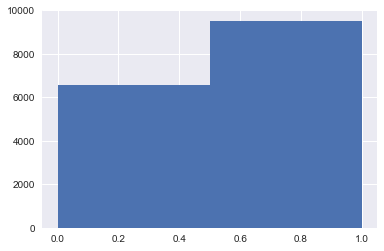

In [69]:
#histogram of injury results
all_crash_data.Injury_Level.hist(bins=2)

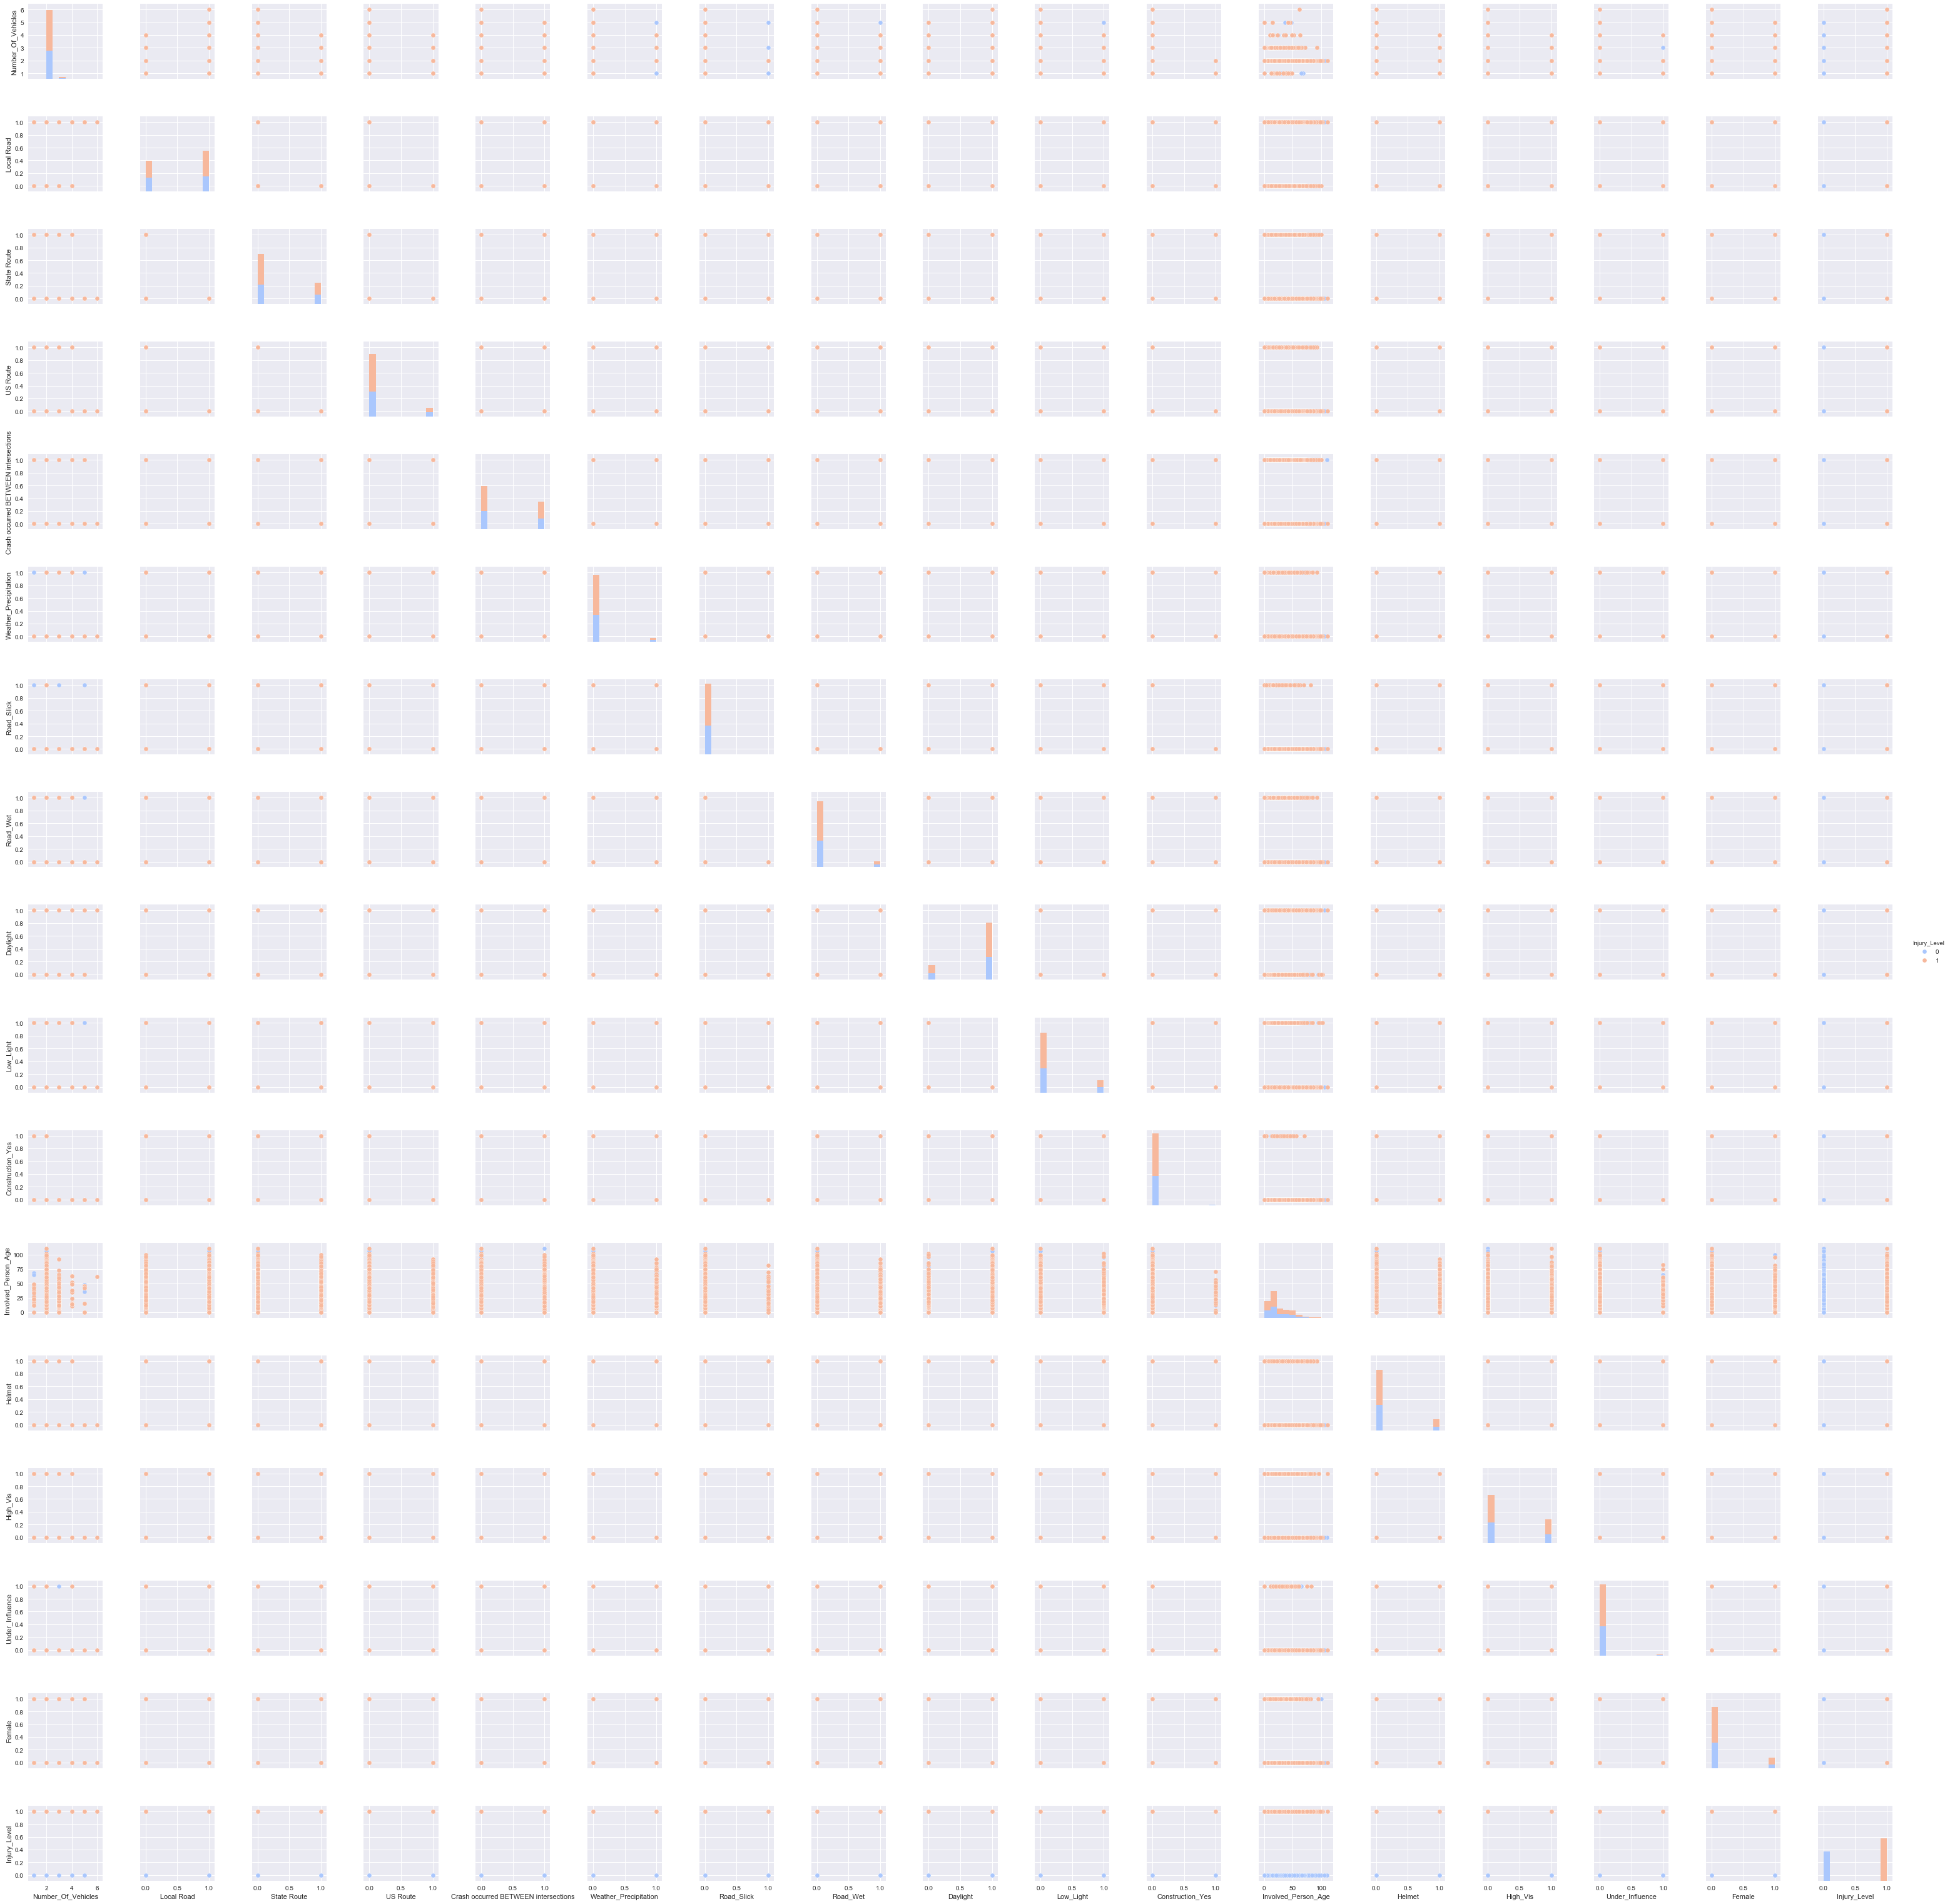

In [7]:
#create a scatter matrix to check out the data
#doesn't really seem to be that helpful because almost all the variables are categorical

X,y = all_crash_data.iloc[:,1:17],all_crash_data.iloc[:,-1]
feature_names= X.columns.tolist()
target_name = all_crash_data.columns.tolist()[-1]

sns.pairplot(all_crash_data[feature_names+['Injury_Level']],hue='Injury_Level', palette='coolwarm')

Accuracy Score:  0.604037267081
Chance:  0.40817805383022776
RMSE:  0.629255697566


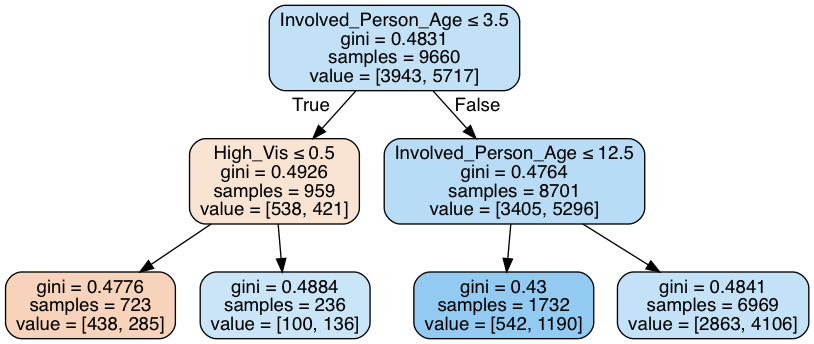

In [22]:
#Testing simple Classification tree 

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.4,random_state=2251540)

classifier_tree = DecisionTreeClassifier(max_depth=2, random_state=1)
classifier_tree.fit(X_train, y_train)

#printing accuracy score vs chance & RMSE
print('Accuracy Score: ', accuracy_score(y_test,classifier_tree.predict(X_test)))
print('Chance: ', 1- (float(y_train.sum())/y_train.shape[0]))
print('RMSE: ', np.sqrt(mean_squared_error(y_test,classifier_tree.predict(X_test))))

dot_data_occ = StringIO()  
export_graphviz(classifier_tree, out_file=dot_data_occ,  
                    feature_names=X_train.columns.tolist(),  
                    filled=True, rounded=True,  
                    special_characters=True)  
occ_graph = pydotplus.graph_from_dot_data(dot_data_occ.getvalue())  
Image(occ_graph.create_png())

#pd.DataFrame({'feature':feature_names, 'importance':occupancy_tree.feature_importances_})

In [19]:
#How many records have an unknown age?
print('Total records with unknown age: ', 
      all_crash_data[all_crash_data.Involved_Person_Age == 0].Involved_Person_Age.count()/
      all_crash_data.Involved_Person_Age.count())

#It's only 10%, let's remove it and try again
all_crash_data_known_age = all_crash_data[all_crash_data.Involved_Person_Age != 0]


Total records with unknown age:  0.0960869565217


In [20]:
#tuning using GridSearchCV 
X_known_age, y_known_age = all_crash_data_known_age.iloc[:,1:17],all_crash_data_known_age.iloc[:,-1]
feature_names_known= X_known_age.columns.tolist()
target_name_known = all_crash_data_known_age.columns.tolist()[-1]

X_train_known,X_test_known,y_train_known,y_test_known = train_test_split(X_known_age,
                                                                         y_known_age,
                                                                         test_size=.4,
                                                                         random_state=2251540)

classifier_tree = DecisionTreeClassifier()

max_depth_range = range(1, 10)
param_grid = dict(max_depth=max_depth_range)
grid = GridSearchCV(classifier_tree, param_grid, cv=10, scoring='neg_mean_squared_error')
grid.fit(X_train_known, y_train_known)


GridSearchCV(cv=10, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_depth': range(1, 10)}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [21]:
#best scores from Tuning
print('Best RMSE: ', np.sqrt(-grid.best_score_))
print(grid.best_params_)

Best RMSE:  0.626688533424
{'max_depth': 6}


(0.6, 1)

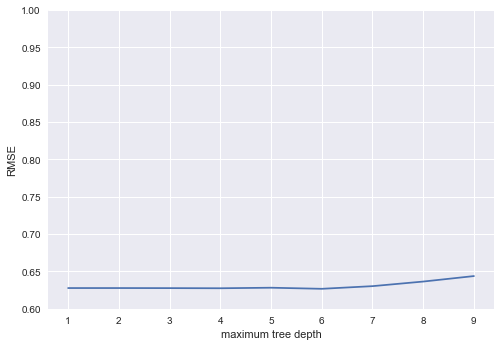

In [12]:
#print(np.sqrt(-grid.cv_results_['mean_test_score']))
sns.mpl.pyplot.plot(max_depth_range,np.sqrt(-grid.cv_results_['mean_test_score']))
sns.mpl.pyplot.xlabel("maximum tree depth")
sns.mpl.pyplot.ylabel("RMSE")
sns.mpl.pyplot.ylim(.6,1)

In [13]:
#results using parameters with best results from tuning

classifier_tree_known = DecisionTreeClassifier(max_depth=4, random_state=1234)
classifier_tree_known.fit(X_train_known, y_train_known)

print('Accuracy Score: ', accuracy_score(y_test_known,classifier_tree_known.predict(X_test_known)))
print('Chance: ', 1- (float(y_train_known.sum())/y_train_known.shape[0]))

#print importances
importances = pd.DataFrame({'feature':feature_names, 'importance':classifier_tree_known.feature_importances_})
print (importances.sort_values(by = 'importance', ascending = False))


Accuracy Score:  0.61130195809
Chance:  0.3939983965181537
                                 feature  importance
11                   Involved_Person_Age    0.440488
12                                Helmet    0.189592
1                             Local Road    0.157109
13                              High_Vis    0.096554
0                     Number_Of_Vehicles    0.063646
8                               Daylight    0.040175
4   Crash occurred BETWEEN intersections    0.012437
2                            State Route    0.000000
3                               US Route    0.000000
5                  Weather_Precipitation    0.000000
6                             Road_Slick    0.000000
7                               Road_Wet    0.000000
9                              Low_Light    0.000000
10                      Construction_Yes    0.000000
14                       Under_Influence    0.000000
15                                Female    0.000000


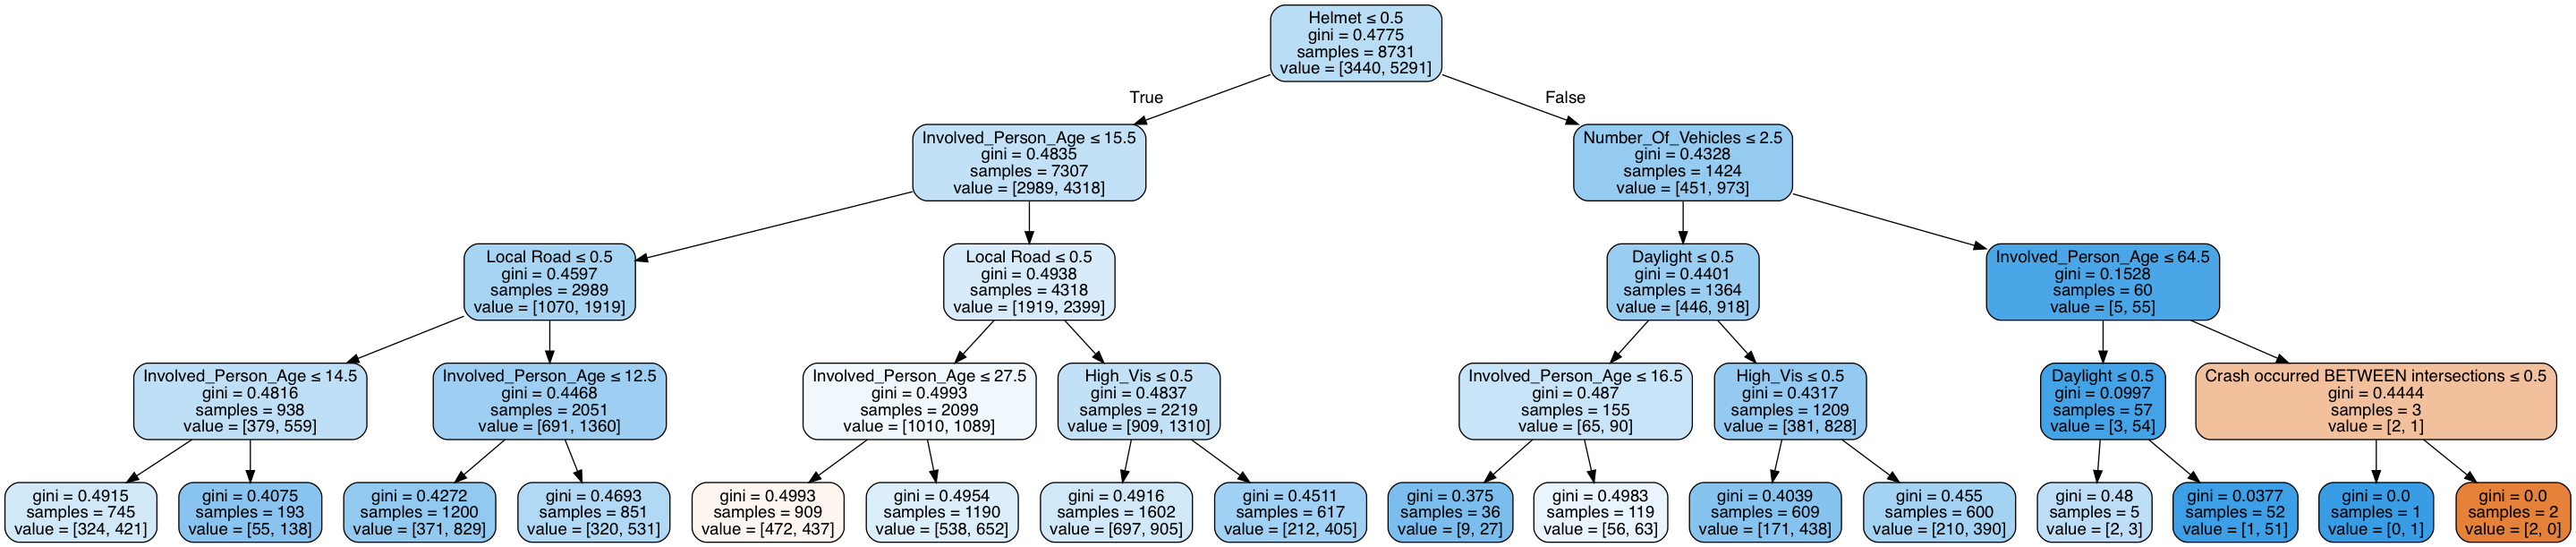

In [15]:
#print tree
dot_data_occ = StringIO()  
export_graphviz(classifier_tree_known, out_file=dot_data_occ,  
                    feature_names=X_train_known.columns.tolist(),  
                    filled=True, rounded=True,  
                    special_characters=True)  
occ_graph = pydotplus.graph_from_dot_data(dot_data_occ.getvalue())  
Image(occ_graph.create_png())


In [ ]:
#Can Random forest do any better? Doesn't seem like it

rf = RandomForestClassifier(n_estimators=50000, bootstrap=True, oob_score=True, random_state=54845)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("Random Forest RMSE:",np.sqrt(mean_squared_error(y_test,y_pred_rf)))

In [17]:
#what happens if we try to scale the data? - looks like it got worse

from sklearn.preprocessing import StandardScaler

#scale based on training data & transform
scaler = StandardScaler()
scaler.fit(X_train_known) 
X_train_scaled = scaler.transform(X_train_known)

#retry GridSearchCV 
classifier_tree = DecisionTreeClassifier()

max_depth_range = range(1, 10)
param_grid = dict(max_depth=max_depth_range)
grid = GridSearchCV(classifier_tree, param_grid, cv=10, scoring='neg_mean_squared_error')
grid.fit(X_train_scaled, y_train_known)

#best scores from Tuning
print('Best RMSE: ', np.sqrt(-grid.best_score_))
print(grid.best_params_)

Best RMSE:  0.626688533424
{'max_depth': 6}


In [27]:
#maybe minmaxscaler? - still not great
from sklearn.preprocessing import MinMaxScaler
minmax= MinMaxScaler()

#scale based on training data & transform
minmax.fit(X_train_known)
X_scaled_minmax = minmax.transform(X_train_known) #transform the data with it

#retry GridSearchCV 
classifier_tree = DecisionTreeClassifier()

max_depth_range = range(1, 10)
param_grid = dict(max_depth=max_depth_range)
grid = GridSearchCV(classifier_tree, param_grid, cv=10, scoring='neg_mean_squared_error')
grid.fit(X_scaled_minmax, y_train_known)

#best scores from Tuning
print('Best RMSE: ', np.sqrt(-grid.best_score_))
print(grid.best_params_)

Best RMSE:  0.626962615454
{'max_depth': 6}
